<a href="https://colab.research.google.com/github/memoandrea/Sinandah/blob/main/Language_modeling_character_based_neural_language_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
#import necessary libraries

import tensorflow as tf
import numpy as np
import pickle
from pickle import load
from pickle import dump
from numpy import array
from keras.models import load_model
from keras.utils import plot_model
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [63]:
#Data preparation

#load text into memory
#function to load text into memory

def load_doc(filename):

  #open the file as read only

  file = open(filename, 'r')

  #read all text

  text = file.read()

  #close the file

  file.close()
  return text

In [64]:
#call the function with the filename

#load text
raw_text = load_doc('Sing.txt')
print(raw_text)

Sing a song of sixpence,
A pocket full of rye.
Four and twenty blackbirds,
Baked in a pie.
When the pie was opened
The birds began to sing;
Wasn't that a dainty dish,
To set before the king.
The king was in his counting house,
Counting out his money;
The queen was in the parlour,
Eating bread and honey.
The maid was in the garden,
Hanging out the clothes,
When down came a blackbird
And pecked off her nose.




In [65]:
#TEXT CLEANING
"""strip all the new-line characters so that we have one long
sequence of characters separated only by the whitespace"""

tokens = raw_text.split()
raw_text = ' '.join(tokens)

In [66]:
#create sequences
"""create input and output sequences used to train the model.
each input sequence will be 10 characters long with one output
character, making it 11 characters long
Organize into sequences of characters."""

length = 10
sequences = list()
for i in range(length, len(raw_text)):

  #select sequence of tokens

  seq = raw_text[i - length :i + 1]

  #store

  sequences.append(seq)
print('Total Sequences: %d' %len(sequences))

Total Sequences: 399


In [67]:
#save sequences
#save tokens to file, one dialog per line
#function

def save_doc(lines, filename):
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

In [68]:
#call this function and save the prepared sequences

#save sequences to file

out_filename = 'char_sequences.txt'
save_doc(sequences, out_filename)

In [69]:
#TRAIN THE LANGUAGE MODEL
""" the model will read encoded characters and predict the
next character in the sequence.
a LSTM-RNN hidden layer will be used to learn the context from
the input sequence in order to make the predictions"""

"""load the prepared character sequence data. once loaded, split
the text by new line to give a list of sequences ready to be encoded."""

#load text into memory
#function to load text into memory

def load_doc(filename):

  #open the file as read only

  file = open(filename, 'r')

  #read all text

  text = file.read()

  #close the file

  file.close()
  return text

In [70]:
#load

in_filename = 'char_sequences.txt'
raw_text = load_doc(in_filename)
lines = raw_text.split('\n')

In [71]:
#encode sequences

""" each unique character will be assigned a specific integer value
and each sequence of characters will be encoded as a sequence of integers"""

chars = sorted(list(set(raw_text)))
mapping = dict((c, i) for i, c in enumerate(chars))



In [72]:
#process each sequence of characters one at a time and use the dictionary
#mapping to look up the integer value for each character

sequences = list()
for line in lines:

  #integer encode line
  encoded_seq = [mapping [char] for char in line]

  #store
  sequences.append(encoded_seq)

In [73]:
#vocabulary size

vocab_size = len(mapping)
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 38


In [74]:
#split inputs and output

sequences = array(sequences)
x, y = sequences [:, : -1], sequences [:, -1]


In [75]:
#one-hot encode each character.

"""each character becomes a vector as long as the vocabulary with a 1
marked for the specific character"""

sequences = [to_categorical(x, num_classes = vocab_size) for x in x]
x = array(sequences)
y = to_categorical(y, num_classes = vocab_size)



In [76]:
#FIT THE MODEL

""" i define the model with an input layer that takes sequences that have 10 time steps
and 38 features for the one hot encoded input features.
i use the 2nd and 3rd dimensions on the input data."""

#define the model

""" MODEL HAS:
single LSTM hidden layer with 75 memory cells chosen with trial and error.
fully connected output layer that outputs one vector with a probability distribution across all characters in the vocabulary.
a softmax activation function is used on the output layer to ensure the output has the properties of a probability distribution."""

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(75, input_shape = (x.shape[1], x.shape[2])))
model.add(Dense(vocab_size, activation = 'softmax'))





In [77]:
#compile model

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',
              metrics = ['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 75)                  │          34,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 38)                  │           2,888 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,088 (144.88 KB)

 Trainable params: 37,088 (144.88 KB)

 Non-trainable params: 0 (0.00 B)

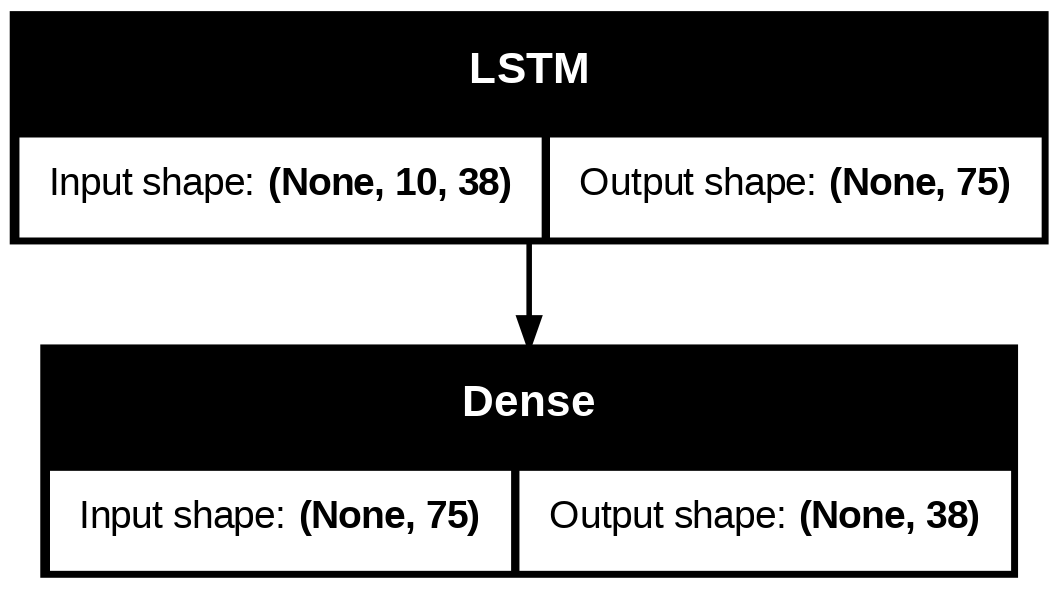

In [78]:
#summarize the defined model

model.summary()
plot_model(model, to_file='model.png', show_shapes=True)


In [79]:
#save the model, including its weights and topology information to a file

model.save('model.h5')

In [80]:
#save the mapping from characters to integers that will be needed to encode any
#input when using the model and decode any output from the model

dump(mapping, open('mapping.pkl', 'wb'))

In [81]:
#generate text

""" use the language model to generate new sequences of text that have
the same statistical properties"""

#load the saved model

model = load_model('model.h5')

#load the pickled dictionary for mapping characters to integers

mapping = load(open('mapping.pkl','rb'))

In [83]:
#generate characters

"""we must provide sequences of 10 characters as input to the model in order to
start the generation process.
a given input sequence will need to be prepared in the same way as preparing the
training data for the model"""

# Define the input text string
in_text = "your input text"
#integer encode the sequence of characters using the loaded mapping

encoded = [mapping[char] for char in in_text]

#one hot encode the integers then reshape the sequence to be 3-dimensional
#as we only have one sequence and LSTMs require an input to be 3D that is;
#samples, time steps and features

encoded = to_categorical(encoded, num_classes = len(mapping))
encoded = encoded.reshape(1, encoded.shape[0], encoded.shape[1])

In [98]:
#use the model to predict the next character in the sequence
yhat = model.predict(encoded, verbose = 0)

# Find the class with the highest probability
yhat = np.argmax(yhat)

#decode this integer by looking up the mapping to see the character to which it maps

out_char = ' '
for char, index in mapping.items():
  if index == yhat:
    out_char = char
    break

In [100]:
#generate a sequence of characters with the language model

def generate_seq(model, mapping, seq_length, seed_text, n_chars):
  in_text = seed_text

In [101]:
#generate a fixed number of characters

for _ in range(n_chars):

  #encode the characters as integers

  encoded = [mapping[char] for char in in_text]

  #truncate sequences to a fixed length

  encoded = pad_sequences([encoded], maxlen = seq_length, truncating = 'pre')

  #one hot encode integers

  encoded = to_categorical(encoded, num_classes = len(mapping))
  encoded = encoded.reshape(1, encoded.shape[0], encoded.shape[1])

  #predict character

  yhat = model.predict(encoded, verbose = 0)

  #reverse map integer to character

  out_char = ' '
  for char, index in mapping.items():
    if index == yhat:
      out_char = char
      break

#append to input
in_text += char
return in_text

ValueError: cannot reshape array of size 140 into shape (1,1,10)